Kai Puolamäki, 3 April 2024

# Should I get Asics METASPEED Sky or Edge?

I.e., am I a "stride runner" or a "cadence runner", and what does it mean?

The exercise was to study the relationship between my stride length and cadence. I was motivated to do this when considering buying Asics METASPEED running shoes. Asics markets METASPEED Sky for "stride runners" who increase their running speed mainly by increasing their stride length, while METASPEED Edge is for "cadence runners" who raise their cadence; see <https://www.asics.com/my/en-my/mk/metaspeed-sky-launch>. The question is: Which shoe should I buy?

First, let's go through some definitions and simple math. Running consists of repeatedly taking strides of a certain length. You could measure the stride length by measuring the distance between your left (or right) footprints. A typical stride length for a runner like me is about one meter. 

The frequency of the strides is called *cadence*, often described as steps per minute, i.e., the number of times the left *and* right foot hits the ground in a minute. A typical running cadence is around 180 steps/minute. The running *speed* is the length travelled in a time interval, here or stride length multiplied by the cadence. For example, if the stride length is 1 m and the cadence is 180 steps/minute, the speed is given by $1\times 180$ m/min or 3 m/s. The running speed is typically expressed as a *pace*, the inverse of the speed, in the units of min/km, i.e., how many minutes it takes to run one kilometre. For example, 3 m/s speed corresponds to a pace of $1/3$ s/m or 5.55 min/km. Therefore, you can quickly compute the third if you know two of the stride, cadence and pace. For example, stride of 1 m and cadence of 180 steps/m corresponds to a pace of 5.55 min/km.

If you are American, then you should replace kilometres with miles.


In this document, I'll analyse my easy run on 1 April 2024. The run was about 10 kilometres long. Most of it was at a leisurely pace of around 6.5 min/km, but I included one-minute intervals at paces of around 6.5, 6, 5.5, 5, 4.5, 4, and 3.5 min/km at the start of the run to get data at different paces. I ran on a relatively flat asphalt/dirt route with HOKA Mach 5 trainers. I recorded the run with my Garmin Forerunner 935 watch.

Disclaimer: I am not a sports physiologist. The conclusions presented below may or may not make sense. Interpret as you see fit.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import xml.etree.ElementTree as ET

<IPython.core.display.Javascript object>

Next, we load and preprocess the Training Center XML (TCX) file I downloaded from a Dropbox folder synced by <https://tapiriik.com/>. You could also fish it out directly from your Garmin. The TCX file comprises Trackpoints, each representing one second of the run. Each trackpoint consists of several measurements. Here, we use Speed (m/s) and Run Cadence (half of the Cadence). By using Speed and Run Cadence, we can compute the Cadence, Pace, and Stride length, as described earlier.

From further analysis, we drop all track points with a pace larger than 9 min/km and a cadence less than 120, as these points represent standing, walking, or track points with bad measurements.

In [2]:
# Define the namespace to access the elements properly
namespaces = {
    "": "http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2",
    "tpx": "http://www.garmin.com/xmlschemas/ActivityExtension/v2",
}

file_path = "2024-04-01_17-12-59_Running.tcx"

# Parse the TCX file
tree = ET.parse(file_path)
root = tree.getroot()

# Initialize lists to store Speed and RunCadence values
speeds = []
run_cadences = []

# Iterate through each trackpoint to extract Speed and RunCadence
for trackpoint in root.findall(".//Trackpoint", namespaces):
    # Extract Speed, which is nested within Extensions -> TPX
    speed = trackpoint.find(".//tpx:Speed", namespaces)
    if speed is not None:
        speeds.append(float(speed.text))

    # Extract RunCadence, which might be directly under Trackpoint or within Extensions -> TPX
    run_cadence = trackpoint.find(".//RunCadence", namespaces)
    if run_cadence is None:
        run_cadence = trackpoint.find(".//tpx:RunCadence", namespaces)
    if run_cadence is not None:
        run_cadences.append(int(run_cadence.text))


speeds = np.array(speeds)
run_cadences = np.array(run_cadences)

# Drop zero speeds and zero cadences
i = np.logical_and(speeds > 0, run_cadences > 0)
speeds = speeds[i]
run_cadences = run_cadences[i]

data = pd.DataFrame(
    {
        "Speed": speeds,  # m/s
        "Cadence": 2.0 * run_cadences,  # steps/min
        "Pace": 60.0 / (speeds * 3.6),  # min/km
        "Stride": 60.0 * speeds / (2.0 * run_cadences),  # m
    }
)

# Drop rows where Pace is more than 9 min/km or Cadence is less than 120.
# This way, we get rid of the non-running trackpoints and measurement errors or missing measurements.
# The filtered data is used in plots and analysis.
pace_limit = 9
cadence_limit = 120

filtered_data = data[(data["Pace"] <= pace_limit) & (data["Cadence"] >= cadence_limit)]

filtered_data.head()

,Speed,Cadence,Pace,Stride
0,2.603,164.0,6.402869,0.952317
1,2.603,168.0,6.402869,0.929643
2,2.603,168.0,6.402869,0.929643
3,2.603,168.0,6.402869,0.929643
4,2.622,168.0,6.356471,0.936429


<IPython.core.display.Javascript object>

Finally, we can prepare a figure of Stride vs Cadence. In the figure, we plotted all track points and contours representing constant pace (recall that we can infer speed and pace once we know stride and cadence!).

Since my relevant race paces (from 5K to half marathon, at least) are between 5 min/km and 4 min/km, I have used only these points to fit a regression line. Modify these to correspond to your preferred pace range, if you want to analyse your running. The slope of the regression line tells how much the cadence changes as the stride length increases with increasing running speed.

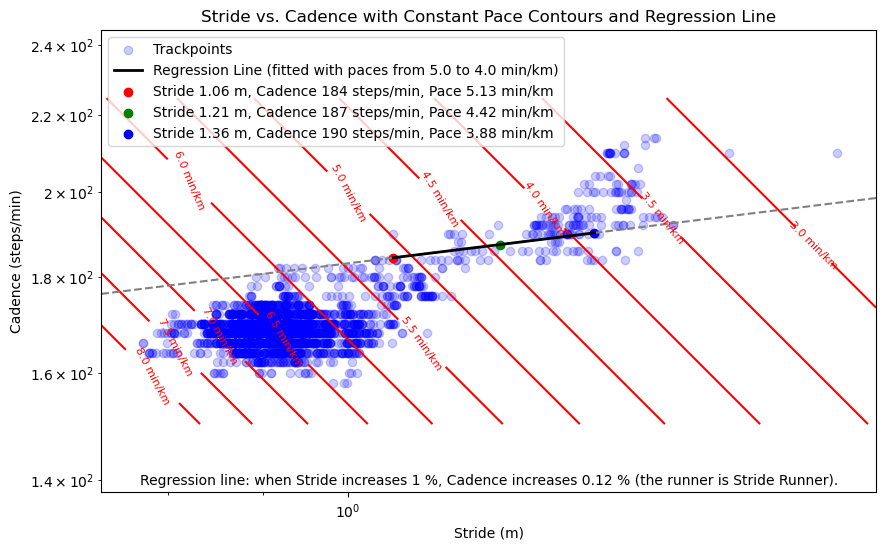

<IPython.core.display.Javascript object>

In [3]:
# Define the contour levels for pace in minutes per kilometer
pace_levels = [3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]

# Pace range used to compute the regression line - modify these appropriately.
reg_pacemin = 4.0
reg_pacemax = 5.0

# Prepare the cadence and stride data
stride = filtered_data["Stride"].values
cadence = filtered_data["Cadence"].values

# Prepare cadence and stride grid for contour plot
stride_range = np.linspace(
    0.95 * filtered_data["Stride"].min(), 1.05 * filtered_data["Stride"].max(), 100
)
cadence_range = np.linspace(
    0.95 * filtered_data["Cadence"].min(), 1.05 * filtered_data["Cadence"].max(), 100
)
stride_grid, cadence_grid = np.meshgrid(stride_range, cadence_range)

# Calculate pace grid for contour plot
pace_grid = 1000.0 / (cadence_grid * stride_grid)  # Pace in min/km

# Filter the data for regression. Do the regression on log-transformed data.
regression_data = filtered_data[
    (reg_pacemin <= filtered_data["Pace"]) & (filtered_data["Pace"] <= reg_pacemax)
]
X = np.log(regression_data[["Stride"]])
y = np.log(regression_data["Cadence"])

# Fit the linear regression model
linreg = LinearRegression()
linreg.fit(X.values, y)

reg_xmin = np.exp(np.min(X))
reg_xmax = np.exp(np.max(X))

# Predict cadence for a range of strides
stride_range_for_line = np.linspace(reg_xmin, reg_xmax, 100).reshape(-1, 1)
predicted_cadence = np.exp(linreg.predict(np.log(stride_range_for_line)))

stride_range_for_line2 = stride_range.reshape(-1, 1)
predicted_cadence2 = np.exp(linreg.predict(np.log(stride_range_for_line2)))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))


# Add contour lines for constant pace
contours = ax.contour(
    stride_grid, cadence_grid, pace_grid, levels=pace_levels, colors="red"
)
ax.clabel(contours, inline=True, fontsize=8, fmt="%1.1f min/km")

# Plot data points
ax.scatter(stride, cadence, c="blue", label="Trackpoints", alpha=0.2)

# Add the regression line
ax.plot(
    stride_range_for_line2,
    predicted_cadence2,
    color="gray",
    label=f"_Regression Line (paces from {reg_pacemax:.1f} to {reg_pacemin:.1f} min/km)",
    linestyle="dashed",
)

ax.plot(
    stride_range_for_line,
    predicted_cadence,
    color="black",
    label=f"Regression Line (fitted with paces from {reg_pacemax:.1f} to {reg_pacemin:.1f} min/km)",
    linewidth=2,
)




stride_range_for_line3 = np.array(
    [(reg_xmin + reg_xmax) / 2.0, 1.01 * (reg_xmin + reg_xmax) / 2.0]
).reshape(-1, 1)
predicted_cadence3 = np.exp(linreg.predict(np.log(stride_range_for_line3)))
incr3 = 100 * (predicted_cadence3[1] - predicted_cadence3[0]) / predicted_cadence3[0]

if incr3 > 1:
    rtype = "Cadence Runner"
else:
    rtype = "Stride Runner"

ax.text(
    0.5,
    0.01,
    f"Regression line: when Stride increases 1 %, Cadence increases {incr3:.2f} % (the runner is {rtype}).",
    verticalalignment="bottom",
    horizontalalignment="center",
    transform=ax.transAxes,
)

stride_range_for_line4 = np.array(
    [reg_xmin, (reg_xmin + reg_xmax) / 2.0, reg_xmax]
).reshape(-1, 1)
predicted_cadence4 = np.exp(linreg.predict(np.log(stride_range_for_line4)))
pace4 = 1000.0 / (stride_range_for_line4[:, 0] * predicted_cadence4)
ax.scatter(
    stride_range_for_line4[0, 0],
    predicted_cadence4[0],
    color="red",
    label=f"Stride {stride_range_for_line4[0,0]:.2f} m, Cadence {predicted_cadence4[0]:.0f} steps/min, Pace {pace4[0]:.2f} min/km",
)
ax.scatter(
    stride_range_for_line4[1, 0],
    predicted_cadence4[1],
    color="green",
    label=f"Stride {stride_range_for_line4[1,0]:.2f} m, Cadence {predicted_cadence4[1]:.0f} steps/min, Pace {pace4[1]:.2f} min/km",
)
ax.scatter(
    stride_range_for_line4[2, 0],
    predicted_cadence4[2],
    color="blue",
    label=f"Stride {stride_range_for_line4[2,0]:.2f} m, Cadence {predicted_cadence4[2]:.0f} steps/min, Pace {pace4[2]:.2f} min/km",
)

x_min, x_max = ax.get_xlim()  # Get the current limits
ax.set_xticks(np.arange(np.floor(x_min * 10) / 10, np.ceil(x_max * 10) / 10, step=0.1))
y_min, y_max = ax.get_ylim()  # Get the current limits
ax.set_yticks(np.arange(np.floor(y_min / 10) * 10, np.ceil(y_max / 10) * 10, step=10))

ax.set_xlabel("Stride (m)")
ax.set_ylabel("Cadence (steps/min)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Stride vs. Cadence with Constant Pace Contours and Regression Line")
ax.axis("equal")
plt.legend(loc="upper left")
plt.show()

The figure contains some interesting features. 

I did most of the run at a leisurely pace of around 6.5 min/km, with a 170 steps/min cadence, which shows as a large number of trackpoints around that pace. As explained earlier, I did also do some running at at faster paces at the start of the run, which shows as trackpoints with paces under 5 min/km.

First, notice that at my race-relevant paces from 5 to 4 min/km, the relationship between stride length and cadence is quite log-linear (one percent increase in stride corresponds to a constant percentage increase in cadence). When my stride length increases by 1%, the cadence only increases by 0.12%. I am, therefore, clearly a stride runner. According to Asics, I should buy METASPEED Sky, not Edge.

My race cadence (at around 4.5 min/km) is around 187 steps/min. [According to the folklore](https://www.mcmillanrunning.com/cadence/), a cadence of around 180 steps/min, is "optimal". The cadence is, however, not constant, and it increases with increasing speed, albeit at least for me, more slowly than the stride length; see <https://youtu.be/1kKhfm8Q0CE> for a nice video about the topic.

Another interesting observation is that my maximal stride length is around 1.5 meters, probably due to my physiology (length of the legs, power, etc.); longer leaps when running are very difficult for me. I could probably jump longer than 1.5 meters, but not for a duration a full running session! For this reason, for faster paces of less than 4 min/km, I increase speed relatively more by increasing my cadence since it is more difficult for me to grow my stride lengths at the fastest pace range. My cadence tops at around 210 steps/min, which together with the maximal stride length of about 1.5 m gives the fastest pace 3.17 min/km that I can uncomfortably sustain for a short while.

On the slower paces, my stride length almost always stays above about 0.85 meters, probably due to my physiology. I am 1.87 meters tall, and taking short strides would be unnatural and funny-looking. For slower paces above 5 min/km, I decrease the speed by dropping relatively more the cadence. My cadence always stays above 160 steps/minute; smaller cadence would feel weird and it would probably be more natural efficient to stop running and start walking. Again, this gives an idea of my slowest comfortable running pace of 7.35 min/km, and may also explain why around 6.5 min/km is the slowest pace I feel comfortable with.

As a result, the stride vs cadence plot is "S-shaped". For my "natural race paces" from 5 to 4 min/km, I primarily increase speed by increasing the stride length, making me a "stride runner", the relation between the stride length and cadence being log-linear: a 1 % increase in stride length results in a 0.12% increase in cadence to a reasonable accuracy. However, for slow speeds (pace above 5 min/km), the cadence is below the linear fit; for very fast speeds (pace below 4 min/km), the cadence is above the linear fit. For the slow and fast speeds, I therefore regulate my speed relatively more with cadence, probably because I hit the physiological lower and upper bounds of my stride length. I therefore move closer to the "cadence runner" at very low or fast speeds.

An interesting observation is that even though often running paces, e.g., for training and various events, are measured in terms of aerobic performance and measures such as VO2max, other physiology also sets some limits. For example, if you want to run fast, it only helps to have excellent aerobic performance if your physiology doesn't cap your cadence and stride length. Conversely, the physiology also may set a lower comfortable running speed. For example, if you don't have enough flexibility and strength to make long strides, your speed is capped. On the other hand, if your aerobic performance is not stellar, it may be that you cannot run easy runs (because even at the slowest comfortable pace your run is not aerobically easy); you may need to replace your easy runs at least partially with slow cycling or fast walks if you want to have training sessions with lower aerobic demands.  I am lucky in that my area of aerobic performance for races from 5K to half marathon seems to match with my physiology in terms of the stride vs cadence curve. However, if a miracle happened and my VO2max increased to allow 15-20 minute 5K, I might need to do something to my stride length at 3-4 min/km paces (I don't worry too much about this miracle happening, though).